In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.special import rel_entr
import os
from python_src.compositions import multiplicative_aitchison, uniform_replace_zeroes
from python_src.figures_utils import get_all_expected, generate_experimental_df, get_relabund_files, fully_combined
from skbio.stats.composition import multiplicative_replacement
from scipy.spatial.distance import braycurtis, euclidean
from scipy.stats import pearsonr
from dataclasses import dataclass
from python_src.compositions import clr
from typing import Tuple, List

# Global Variables

In [116]:
# Change this depending on your data.
# taxonomic_rank = 'Species'
base_path = "pipelines/camisimGI/bio4"
rel_abund_file = "s1_genus_relabund.csv"
program_name = "Biobakery4"
sample_id = "s1"

expected_input = "pipelines/camisimGI/s1_expected.csv"

pdf_output = PdfPages("figures.pdf")

## Utils

In [117]:
# Use this once scipy fixes the bug.
# from skbio.stats.composition import clr
# from scipy.spatial.distance import euclidean

# def aitchinson_distance(x, y):
#     return euclidean(clr(x), clr(y))

## Colors For Seaborn and MatplotLib

In [118]:
cb_palette = sns.color_palette(as_cmap=True)

color_palette = {
    "Expected": cb_palette[0], 
    "expected": cb_palette[0], 
    "woltka": cb_palette[1], 
    "wol": cb_palette[1], 
    "jams": cb_palette[2], 
    "wgsa": cb_palette[3], 
    "wgsa2": cb_palette[3], 
    "biobakery3": cb_palette[4], 
    "bio3": cb_palette[4], 
    "biobakery4": cb_palette[5], 
    "bio4": cb_palette[5]
}

# One Sample, One Expected

In [119]:
def generate_expected(input_path: str, plot: bool = False, rank : str = "Genus") -> pd.DataFrame:
    """
    Parameters:
        input_path: str 
            Path to the expected abundance file.
        plot: bool
            Whether to plot the expected abundances.
        rank: str
            The taxonomic rank to use. Default is "Genus".
    Returns:
        expected: pd.DataFrame
            The expected abundances in a dataframe. The format is | rank | abundance |.

    Generates the expected result from the tsv file. Returns a dataframe. THIS IS ONLY FOR BMOCK12.
    """
    # expected = pd.read_csv(input_path, sep=',', index_col=0, names=['Organism', 'Counts', 'TAX_ID'], header=0)
    expected = pd.read_csv(input_path, sep=',', index_col=0, names=['Organism', 'Counts'], header=0)
    expected = expected[['Counts']].astype(int)

    # Calculate expected relative abundance. If it's already in RA, this won't change anything.
    expected['RA'] = expected['Counts'] / expected['Counts'].sum()

    if rank == "Species":
        expected.sort_values(by=['RA'], ascending=False, inplace=True)
        return expected

    # Let's split the organism index into two columns to find the genera.
    orgs = expected.index.to_list()
    genus = [org.strip().split(' ')[0] for org in orgs]
    # genus = [x.replace('M.', 'Micromonospora') for x in genus]

    # Apparently, propionibacterium have been renamed to cutibacterium.
    # genus = [x.replace('Propionibact.', 'Cutibacterium') for x in genus]

    # Add the columns to the dataframe.
    expected['Genus'] = genus
    # display(expected.head(12))

    # Group by genus and sum the counts for overlapping genera.
    exp_genus = expected.groupby('Genus').sum()
    exp_genus.sort_values('RA', ascending=False, inplace=True)

    if plot:
        exp_genus.plot.bar(y='RA', figsize=(8, 5), legend=False, title='Expected Relative Abundance')
    
    return exp_genus

# Use generate_expected to generate the expected result for the bmock12 data.
# exp_genus = generate_expected('pipelines/bmock12/s1_raw_expanded.csv', False, "Species")
# exp_genus["RA"].to_csv('pipelines/bmock12/s1_expected_species.csv', index_label="Species")

In [120]:
# For camisim, we can just read the csv in directly.
# exp_genus = pd.read_csv(expected_input, index_col=0, names=['Genus', 'RA'], header=0)
# exp_genus = exp_genus.where(exp_genus['RA'] > 0.001).dropna()

# (exp_genus.where(exp_genus['RA'] > 0.001).dropna()).to_csv('pipelines/camisimGI/s2_genus_pretty.csv', index_label="Genus")

In [121]:
# Instead, let's concat the two dataframes into long format and add a column from where it originated.
def long_format(df1, df2):
    merged = pd.concat([df1, df2], axis=0)

    # !!! This is slick
    merged['Source'] = ['Expected'] * len(df1) + ['Observed'] * len(df2)

    return merged

# result_genus = generate_experimental_df(os.path.join(base_path, rel_abund_file), taxonomic_rank)
# display(result_genus.head(12))
# merged_lf = long_format(exp_genus, result_genus)

# Plotting Tools

In [122]:
def linear_regression(df: pd.DataFrame, exp_df: pd.DataFrame, plot: bool = False, save_path: str = None) -> pd.DataFrame:
    # Merge on the genus key for easy plotting. The expected results are on the left, the observed on the right.
    # linear_df = exp_genus.merge(df, left_index=True, right_index=True)

    # try join because the left merge will drop the genera that are not in the observerd results, but we want to show that the experimental missed it.
    linear_df = exp_df.join(df, how='left', lsuffix='_x', rsuffix='_y')
    linear_df.fillna(0, inplace=True)

    # Linear regression with scikit.
    X = linear_df['RA_x'].values.reshape(-1, 1)
    Y = linear_df['RA_y'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, Y)
    y_pred = reg.predict(X)

    # Scatter plot of RA_x vs. RA_y.
    if plot:
        fig = plt.figure(figsize=(10, 8))
        plt.scatter(linear_df['RA_x'], linear_df['RA_y'], color='black')

        # Calculate mean absolute error.
        mae = np.mean(np.abs(linear_df['RA_x'] - linear_df['RA_y']))

        # Regression line.
        plt.plot(X, y_pred, color='red', linewidth=2)
        # Labels.
        plt.xlabel('Expected Relative Abundance')
        plt.ylabel('Observed Relative Abundance')
        plt.title(f'Expected vs. Observed Relative Abundance for {program_name} {taxonomic_rank}')

        # Add r^2 value.
        plt.text(0.1, 0.9, f'r^2 = {reg.score(X,Y):.4f}', transform=plt.gca().transAxes)
        # Add MAE.
        plt.text(0.1, 0.85, f'MAE = {mae:.4f}', transform=plt.gca().transAxes)

        # Add line y = x.
        plt.plot([0, 1], [0, 1], color='blue', linewidth=2, linestyle='--')

        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        # plt.show()

    return linear_df
    
# linear_regression(result_genus, exp_genus, plot=True, save_path=os.path.join(base_path, f"{sample_id}_bivariate_{taxonomic_rank}.png"))

In [123]:
def fix_x_labels(ax, df, rank):
    xticks = ax.get_xticklabels()
    # print(xticks)
    new_labels = []
    for x in xticks:
        res = df.loc[int(x.get_text()), rank]
        # Get only the first row from the series.
        # This is necessary because if it is unique, it will return a string, but if it is not unique, it will return a series.
        if isinstance(res, pd.Series):
            res = res.iloc[0]
        new_labels.append(res)

    return new_labels

In [124]:
# Bar plot of RA_x vs. RA_y side by side.
# sns.set_style("whitegrid")
def bar_plot(df: pd.DataFrame, plot: bool = False, save_path: str = None, program: str = program_name, title: str =f'INSERT TITLE', hue_category: str ='Source', taxonomic_rank: str = None, threshold: float = 5e-5):
    # df.to_csv("debug.csv", index=True)
    subset = pd.DataFrame()

    # Used to subset by taxonomic rank, but now TAX_ID?
    # Need to test further.
    for x, y in df.groupby("TAX_ID"):
        if y["Source"].values[0] == "Expected":
            subset = pd.concat([y, subset], axis=0)

    # display(subset.head())
    subset = subset.where(subset['RA'] > threshold).dropna()
    # subset.to_csv("subset.csv", index=True)

    if plot:
        # Plot a category bar chart with the colors based on the source.
        fig = plt.figure(figsize=(10, 8))
        ax = sns.barplot(x=subset.index, y='RA', hue=hue_category, data=subset, errorbar=None, palette=color_palette)
        ax.semilogy()

        ax.bar_label(ax.containers[0], fmt='%.2e', label_type='center')
        # ax.bar_label(ax.containers[1], fmt='%.2e', label_type='edge')

        # Change the x axis labels from the index to the taxonomic rank.
        ax.set_xticklabels(fix_x_labels(ax=ax, df=subset, rank=taxonomic_rank), rotation=45, horizontalalignment='right')

        # Later, we can fix the y labels.
        # fix_y_labels(ax)

        ax.set_title(title)
        ax.set_xlabel(taxonomic_rank)
        ax.set_ylabel('Relative Abundance')

        if save_path is not None:
            pdf_output.savefig(fig, dpi=300, bbox_inches='tight')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()

        plt.show()

# bar_plot(merged_lf, plot=True, save_path=os.path.join(base_path, f"{sample_id}_bars_{taxonomic_rank}.png"))

# Multisample
## Utilities

In [125]:
def fix_outer_join_df(df: pd.DataFrame, source: str, threshold: float = 0.001) -> pd.DataFrame:
    """
    Parameters:
        df: The dataframe to fix.
        source: The source of the dataframe.
        threshold: The threshold to use for the relative abundance.
    
    Returns:
        pd.Dataframe: The fixed dataframe.

    This function will fill the missing RA_expected, RA_observed, and Source_observed columns with 0s and the source name. \\ 
    We then filter out the rows where the RA_expected is less than the threshold. \\
    We are doing this to penalize the pipeline for adding taxa that are not in the expected.
    """
    # print("the threshold is ", threshold)
    df['RA_expected'].fillna(0, inplace=True)
    df['RA_observed'].fillna(0, inplace=True)
    df['Source_observed'].fillna(source, inplace=True)

    # Now, filter any rows with 'RA_observed' less than threshold if the corresponding RA_expected value is 0.
    # df = df.loc[(df['RA_expected'] > 0) | (df['RA_observed'] > threshold)]

    # # If the RA_expected is greater than zero, if the RA_observed is less than the threshold, then set the RA_observed to 0.
    # df.loc[(
    #     (df['RA_observed'] < threshold) &
    #     (df['RA_expected'] > threshold) & 
    #     (abs(df['RA_observed'] - df['RA_expected']) > df['RA_expected'] * 0.10)), 'RA_observed'] = 0

    # Just filter everything.
    new_df_filter = df.loc[(df['RA_observed'] > threshold) | (df['RA_expected'] > threshold)]

    return new_df_filter

### Renormalize

In [126]:
def renormalize_df(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Parameters:
        df: The dataframe to renormalize.

    Returns:
        pd.DataFrame: The renormalized dataframe.

    This function will renormalize the relative abundance. \\
    Specify the column name to renormalize.
    """
    # Renormalize the experimental dataframes.
    df[column_name] = df[column_name] / df[column_name].sum()

    return df


### Join functions for the bivariate plots

In [127]:
def join_left(expected: pd.DataFrame, source_df: pd.DataFrame, source_name: str, sampleID: str) -> pd.DataFrame:
    """ 
    Parameters:
        expected: The expected dataframe.
        source_df: The source/experimental dataframe.
        source_name: The name of the source.
        sampleID: The sampleID of the source (can be None).
    Returns:
        pd.DataFrame: The joined dataframe.

    This function will join the expected dataframe to the source dataframe by left join. \\
    Then, it will fill the missing observed values with 0s and the source name, since there can be no missing expected values. \\.

    """
    exp_copy = expected.copy()
    src_copy = source_df.copy()

    # Only select where the expected RA is greater than 0.
    exp_copy = exp_copy.loc[exp_copy['RA'] > 0]

    merged = pd.merge(exp_copy, src_copy, on="TAX_ID", how='left', suffixes=('_expected', '_observed'))
    merged['RA_observed'].fillna(0, inplace=True)
    merged['Source_observed'].fillna(source_name, inplace=True)
    if sampleID is not None:
        merged['SampleID'] = sampleID

    return merged

def join_left_replicates(expected: pd.DataFrame, source_df: pd.DataFrame, source_name: str, rank: str) -> pd.DataFrame:
    """
    Parameters:
        expected: The expected dataframe.
        source_df: The source/experimental dataframe.
        source_name: The name of the source (pipeline name).
        rank: The rank of the dataframe.
    Returns:
        pd.DataFrame: The joined dataframe.

    This function will join the expected dataframe to the source dataframe by left join. \\
    However, for replicates, the missing observed values will be assigned the sampleID from the group it's missing from. \\
    This is necessary because previous the groupby function would ignore these without sampleIDs.
    """
    # We want to join the expected dataframe to the source dataframe by left join.
    # However, we want to group by SampleID first and join only those with the same SampleID.
    # Then, we want to fill the missing observed values with 0s and the source name, since there can be no missing expected values.

    exp_copy = expected.copy()
    src_copy = source_df.copy()

    final_df = pd.DataFrame()

    # Only select where the expected RA is greater than 0.
    exp_copy = exp_copy.loc[exp_copy['RA'] > 0]

    # Group by SampleID and join only those with the same SampleID.
    for sampleID, src_df in src_copy.groupby('SampleID'):
        # Subset the sampleID in the source dataframe.
        merged = pd.merge(exp_copy, src_df, on="TAX_ID", how='left', suffixes=('_expected', '_observed'))
        merged['RA_observed'].fillna(0, inplace=True)
        merged['Source_observed'].fillna(source_name, inplace=True)
        merged['SampleID_observed'].fillna(sampleID, inplace=True)

        # Find rows with NaN genus, and fill with the corresponding genus from the expected dataframe by querying the TAX_ID.
        null = merged.loc[merged[rank].isna()]

        # Find the corresponding genus from the expected dataframe by querying the TAX_ID.
        for index, row in null.iterrows():
            name = exp_copy.loc[exp_copy['TAX_ID'] == row['TAX_ID']].index[0]
            merged.at[index, rank] = name

        final_df = pd.concat([final_df, merged], axis=0)
    
    return final_df


In [128]:
def check_and_fill_missing(merged_df: pd.DataFrame, expected_df: pd.DataFrame, col: str):
    """This function will check if there are any missing values in the "genus" or "species" columns.
    If there are, it will fill them with the corresponding genus or species from the expected dataframe.
    """
    # Find rows with NaN genus, and fill with the corresponding genus from the expected dataframe by querying the TAX_ID.
    null = merged_df.loc[merged_df[col].isna()]

    # Find the corresponding genus from the expected dataframe by querying the TAX_ID.
    for index, row in null.iterrows():
        name = expected_df.loc[expected_df['TAX_ID'] == row['TAX_ID']].index[0]
        merged_df.at[index, col] = name

    return merged_df

In [129]:

def join_outer(expected: pd.DataFrame, source_df: pd.DataFrame, source_name: str, threshold: float, replicates: bool) -> pd.DataFrame:
    """
    This function will join the expected dataframe to the source dataframe by outer join. \\
    Then it will call fix_outer_join_df to fix the missing values and filter out the rows with RA_expected less than the threshold.
    See: :func:`fix_outer_join_df`

    ### Parameters:
        expected: The expected dataframe.
        source_df: The source/experimental dataframe.
        source: The name of the source.
        sample: The sampleID of the source (can be None).
        threshold: The threshold to use for the relative abundance.
        replicates: Whether or not the source is replicates. If so, the renormalization will occur by sampleID.
    ### Returns:
        pd.DataFrame: The joined dataframe.
    """
        
    exp_copy = expected.copy()
    src_copy = source_df.copy()
    
    # THIS RENORMALIZATION NEEDS TO OCCUR BY SAMPLEID.
    if replicates:
        replicate_df = pd.DataFrame()
        for smpl, smpl_df in src_copy.groupby('SampleID'):
            merged = pd.merge(exp_copy, smpl_df, on="TAX_ID", how='outer', suffixes=('_expected', '_observed'))
            merged = fix_outer_join_df(merged, source_name, threshold=threshold)
            merged = renormalize_df(merged, 'RA_observed')
            merged = renormalize_df(merged, 'RA_expected')

            # Fill in any missing sampleID_observed values.
            merged['SampleID_observed'].fillna(smpl, inplace=True)

            replicate_df = pd.concat([replicate_df, merged], axis=0)
        try:  
            replicate_df = check_and_fill_missing(replicate_df, expected, 'genus')
        except KeyError:
            replicate_df = check_and_fill_missing(replicate_df, expected, 'species')
        
        return replicate_df
        
    else:
        merged = pd.merge(exp_copy, src_copy, on="TAX_ID", how='outer', suffixes=('_expected', '_observed'))

        merged = fix_outer_join_df(merged, source_name, threshold=threshold)

        merged = renormalize_df(merged, 'RA_observed')
        merged = renormalize_df(merged, 'RA_expected')

        try:  
            merged = check_and_fill_missing(merged, expected, 'genus')
        except KeyError:
            merged = check_and_fill_missing(merged, expected, 'species')

        return merged

## Multisample with Different Expected Values

In [130]:
def plot_by_sample(root, output_dir, taxonomic_rank, hue_category='Source', threshold=5e-5): 
    """
    Parameters:
        root: The root directory of the data.
        output_dir: The output directory to save the plots.
        taxonomic_rank: The taxonomic rank to plot.
        hue_category: The category to use for the hue.
        threshold: The threshold to use for the relative abundance. Values below this will not be plotted in the bar plot.
    
    This function will plot the relative abundance by sample for the specified taxonomic rank in bar format.
    """
    full_df = fully_combined(root, rank=taxonomic_rank)
    
    experiment_name = os.path.basename(root)
    # print(root, experiment_name)

    for sample_id, df in full_df.groupby('SampleID'):
        title = f"Expected vs. Observed Relative Abundance for {sample_id} in Experiment {experiment_name} ({taxonomic_rank})"
        # display(df.head())
        if output_dir is not None:
            bar_plot(df, plot=True, save_path=os.path.join(output_dir, f"{sample_id}_bars_{taxonomic_rank}_all.png"), title=title, taxonomic_rank=taxonomic_rank, hue_category=hue_category, threshold=threshold)
        else:
            bar_plot(df, plot=True, save_path=None, title=title, taxonomic_rank=taxonomic_rank, hue_category=hue_category, threshold=threshold)

# plot_by_sample(root_dir, hue_category='SampleID')

In [131]:
def non_clr_plot(input_df: pd.DataFrame, hue_category: str, colors: dict, title: str):
    lin_df = input_df.copy()
    # Drop the rows with 0s in the RA_expected.
    lin_df = lin_df[lin_df['RA_expected'] > 0]

    # lin_df.to_csv("lin_df.csv", index=True)

    ax_lin = sns.lmplot(x="RA_expected", y="RA_observed", hue=hue_category, col=hue_category, col_wrap=3, data=lin_df, fit_reg=False, height=7, aspect=1, ci=None, palette=colors)

    # Add the R^2 value to the plot.
    def annotate(data, **kws):
        max_x = data['RA_expected'].max()
        max_y = data['RA_observed'].max()
        max_val = max(max_x, max_y)

        x = data["RA_expected"].values.reshape(-1, 1)
        y = data["RA_observed"].values.reshape(-1, 1)

        reg, y_pred = linear_regression(y,x)
        r2 = reg.score(y, x)

        mae = np.mean(np.abs(y - x))

        ax = plt.gca()

        ax.text(.05, .8, 'r2={:.4f}'.format(r2),
                transform=ax.transAxes)

        # Get the data from the plot.
        ax.plot([0, max_val], [0, max_val], color='black', linestyle='--')

        # Make it log scale.

    ax_lin.map_dataframe(annotate)

    ax_lin.fig.suptitle(title, fontsize=16, y=1.05)
    plt.close(ax_lin.fig)
    pdf_output.savefig(ax_lin.figure, bbox_inches='tight', dpi=300)
    
    # Make this a log-log plot.
    # ax.set(xscale="log", yscale="log")

In [132]:
def calc_amos_stats(df: pd.DataFrame) -> Tuple[float, float]:
    def outer_sensitivity(df: pd.DataFrame):
        """Sensitivity: (correctly identified / total) * 100"""
        # The correct identified is where both the RA_expected and RA_observed are greater than 0.
        correct = df[(df['RA_expected'] > 0) & (df['RA_observed'] > 0)].shape[0]

        # The total is the number of rows where the RA_expected is greater than 0.
        total = df[df['RA_expected'] > 0].shape[0]

        # print(f"Correct: {correct}, Total: {total}")

        return (correct / total) * 100

    def outer_join_FPRA(df: pd.DataFrame) -> float:
        """False Positive Rate: abundance of incorrectly identified taxa / total abundance of all taxa"""
        # For the outer join, the incorrectly identified taxa are the rows where the RA_expected is 0.
        # We want to sum up the RA_observed column for these rows.
        incorrect = df[df['RA_expected'] == 0]['RA_observed'].sum()

        # Try to find a row with TAXID == 12908
        try: 
            unclassified = df.loc[12908]['RA_observed']
        except KeyError:
            unclassified = 0

        # The unclassified abundance should be subtracted from this total, if it exists.
        # While it is not expected, it is a different category than the incorrectly identified.
        # This is so that we can agree with the pipeline_plotting scripts.
        incorrect -= unclassified

        # The total may not always be 1. The total is the sum of the RA_expected column.
        result = (incorrect / df['RA_observed'].sum()) * 100
        return result

    return outer_sensitivity(df), outer_join_FPRA(df)

In [133]:
def linear_regression(X, Y):
    """
    Parameters:
        X: The independent variable.
        Y: The dependent variable.
    Returns:
        reg: The linear regression model.
        y_pred: The predicted values.
    
    Performs the linear regression on the data using the sklearn library.

    """
    reg = LinearRegression().fit(X, Y)
    y_pred = reg.predict(X)

    return reg, y_pred

def get_min_and_max_values(df: pd.DataFrame) -> Tuple[float, float]:
    """
    Gets the minimum and maximum values from the dataframe along the RA_expected_clr and RA_observed_clr columns. \\
    This is used to set the limits of the plot in the CLR space.
    """
    # Get the max x and max y values.
    max_x = df['RA_expected_clr'].max()
    max_y = df['RA_observed_clr'].max()
    max_val = max(max_x, max_y)

    min_x = df['RA_expected_clr'].min()
    min_y = df['RA_observed_clr'].min()
    min_val = min(min_x, min_y)

    return max_val, min_val


def linear_plot_stats(df: pd.DataFrame, heading: str, pipeline_offset: float, diversity_value: float) -> pd.DataFrame:
    """ 
    Parameters:
        df: pd.DataFrame
            The dataframe to use for the linear plot.
        heading: str
            The heading to use for the plot.
        pipeline_offset: float
            The offset to use for the pipeline.
        diversity_value: float 
            The diversity value to use for the pipeline.

    Returns:
        pd.DataFrame: The dataframe with the stats for the linear plot.
            In form of: heading | diversity_value | r2 | mae | a_d | bc | rmse | sens | fpra.  

    Calculates the statistics for the linear plot and return them in a dataframe.
    """
    stats_list = [heading, diversity_value]

    # The R^2, MAE, RMS, and BC are calculated on the non-transformed data.
    x = df["RA_expected"].values.reshape(-1, 1)
    y = df["RA_observed"].values.reshape(-1, 1)

    # We should probably perturb the x and y the same way we do the Aitchison values. 
    # For now, we will calculate the linear regression on the original values.
    reg, y_pred = linear_regression(y, x)

    # Calculate R^2.
    r2 = reg.score(y, x)
    stats_list.append(r2)

    # Calculate MAE.
    mae = np.mean(np.abs(y - x))
    stats_list.append(mae)

    # Add the aitchison distance.
    try: 
        a_d = euclidean(df['RA_expected_clr'].values, df['RA_observed_clr'].values)
        stats_list.append(a_d)

    except ValueError as e:
        # If there is a zero in the data, we cannot calculate the aitchison distance.
        print(f"ValueError: {e}")
        stats_list.append(np.NaN)

    # Add the bray-curtis distance.
    try: 
        bc = 1 - braycurtis(df['RA_expected'].values, df['RA_observed'].values)
        stats_list.append(bc)

    except ValueError:
        stats_list.append(np.NaN)

    # Add the RMSE distance.
    rms = mean_squared_error(x, y, squared=False)
    stats_list.append(rms)

    # Add the amos stats.
    # print(heading)
    # df.to_csv("amos_df.csv", index=True, header=True, mode='a')
    stats_list.extend(calc_amos_stats(df))

    stats_df = (pd.DataFrame(stats_list, index=['Source/Pipeline', 'Diversity', 'R^2', 'MAE', 'AD', '1-BC', 'RMSE', 'Sens', 'FPRA']).T).set_index('Source/Pipeline')

    return stats_df

In [134]:
def make_minimum(s: pd.Series):
    minimum = s[s > 0].min()
    return minimum / 10

In [135]:
def linear_plot(input_df: pd.DataFrame, title: str, sample_id: str, diversity_dict: dict, hue_category="Source_observed", save_path=None, inset=False, colors=color_palette, linear=False) -> pd.DataFrame:
    """
    Plot a linear regression of the expected vs. observed relative abundance. Also calculates the R^2 value, MAE, RMSE, and Aitchison distance.
    Parameters:
        input_df: A dataframe with the expected and observed relative abundance. The third column should be the source of the data.
        title: The title of the plot.
        sample_id: The sample ID of the plot.
        diversity_dict: A dictionary of the diversity values by grouping variable (hue category).
        hue_category: The category to use for the hue (default: "Source_observed").
        save_path: The path to save the plot to (if None, the plot will not be saved).
        inset: Whether or not to plot the inset.
        linear: Whether add plots of the non-CLR data.
    Returns:
        A dataframe with the R^2, MAE, Aitchison distance, BC, and RMSE with pipeline and sampleID.
    
    Plots the expected vs. observed relative abundance and plots the CLR transformed data. \\
        Also calculates the statistics for the plot and returns them in a dataframe.
    """
    # display(input_df.head())
    stats_df = pd.DataFrame()

    fig = plt.figure(figsize=(10, 10))

    # We need to transform the data to clr space before we plot.
    plot_df = pd.DataFrame()
    for heading, dataframe in input_df.groupby(hue_category):
        # The constant value should be one order of magnitude smaller than the smallest NONZERO in the dataframe.
        exp_minimum = make_minimum(dataframe['RA_expected'])
        obs_minimum = make_minimum(dataframe['RA_observed'])

        # print("minimums: ")
        # print(exp_minimum, " ", obs_minimum)

        append_df = pd.DataFrame({
            # "RA_expected_clr": clr(multiplicative_replacement(dataframe["RA_expected"], minimum)), 
            # "RA_observed_clr": clr(multiplicative_replacement(dataframe["RA_observed"], minimum)), 
            "RA_expected_clr": clr(multiplicative_replacement(dataframe["RA_expected"], exp_minimum)), 
            "RA_observed_clr": clr(multiplicative_replacement(dataframe["RA_observed"], obs_minimum)),
            "Source_observed": heading,
            "RA_expected": dataframe["RA_expected"],
            "RA_observed": dataframe["RA_observed"],
            "SampleID_observed": dataframe["SampleID_observed"]}
        )

        plot_df = pd.concat([plot_df, append_df], axis=0)

    ax = sns.lmplot(x="RA_expected_clr", y="RA_observed_clr", hue=hue_category, col=hue_category, col_wrap=3, data=plot_df, fit_reg=False, height=7, aspect=1, ci=None, palette=colors)

    # Plot the non-CLR data if linear is wanted.
    if linear:
        non_clr_plot(plot_df, hue_category, colors, title)

    pipeline_offset = -0.1
    for heading, dataframe in plot_df.groupby(hue_category):
        # print(heading, diversity_dict[heading])
        # Convert the stats list to a dataframe, transpose it for rows, then concat it to the stats_df.
        stats_data = linear_plot_stats(dataframe, heading, pipeline_offset, diversity_dict[heading])
        stats_df = pd.concat([stats_df, stats_data], axis=0)
        pipeline_offset -= 0.05

    row_colors = None
    # Get the colors of the rows by referencing the color palette with the index names.
    try:
        # Try to assign to the color palette.
        row_colors = [colors[x] for x in stats_df.index.tolist()]
    except TypeError:
        # If we can't (replicate communities), use the default color.
        row_colors = colors
        
        # Convert all of the columns to floats.
        stats_df = stats_df.astype(float)

        # Add the average for the replicates.
        stats_df.loc['Average'] = stats_df.mean(numeric_only=True, axis=0)

    stats_df.update(stats_df[['R^2', 'MAE', 'AD', '1-BC', 'RMSE', 'Sens', 'FPRA']].applymap(lambda x: abs(x)).applymap('{:^.4f}'.format))
    stats_df[['Diversity']] = stats_df[['Diversity']].applymap('{:^.0f}'.format)
    plt.table(cellText=stats_df.values,
        colLabels=stats_df.columns,
        rowLabels=stats_df.index, 
        rowColours=row_colors,
        loc='bottom', 
        fontsize=14, 
        bbox=[0.0, -0.65, 1.0, 0.5], 
        colWidths=[0.50]*len(stats_df.columns))

    # Add title.
    ax.fig.suptitle(title, fontsize=16, y=1.05)

    # Plot a line from (min-0.1, min-0.1) to (max_x+0.1, max_y+0.1) on all facets.
    max_val, min_val = get_min_and_max_values(plot_df)
    for a in plt.gcf().axes:
        a.plot([min_val - 0.01, max_val + 0.01], [min_val - 0.01, max_val + 0.01], ls="--", c=".3")

    # Add an inset for the x values between 0 and 0.05.
    if inset:
        pass
        # left, bottom, width, height = [0.65, 0.15, 0.25, 0.25]
        # ax2 = ax.fig.add_axes([left, bottom, width, height])
        # ax2 = sns.scatterplot(x="RA_expected", y="RA_observed", hue=hue_category, data=input_df, ax=ax2, legend=False, palette=colors)
        # ax2.set_xlim(-0.001, 0.02)
        # ax2.set_ylim(-0.001, 0.02)
        # ax2.set_title("Zoomed In")

    # display(stats_df)

    if save_path is not None:
        pdf_output.savefig(ax.figure, bbox_inches='tight', dpi=300)
        plt.close(ax.figure)
        

    return stats_df

In [136]:
def linear_plot_log(input_df: pd.DataFrame, title, sample_id, hue_category="Source_observed", save_path=None):
    # We want to plot the x and y axis on a log scale.
    fig = plt.figure(figsize=(20, 20))
    ax = sns.lmplot(x="RA_expected", y="RA_observed", hue=hue_category, data=input_df, fit_reg=True, height=7, aspect=11/7, ci=None, truncate=True)
    # ax.set(xscale="symlog", yscale="symlog")

In [137]:
def cleanup_bivariate_stats(df: pd.DataFrame, sampleID: str):
    """
    Parameters:
        df: The dataframe to clean up.
        sampleID: The sampleID to use for the index.

    Since the sampleID and pipeline are changed depending on the hue color (for replicates), we need to change it here.
    """

    # We need to add a column equal to sampleID.
    df['SampleID'] = sampleID

    # Pop the old index.
    df.reset_index(inplace=True)

    # Set the index as the sampleID.
    df.set_index(['SampleID'], inplace=True)

    # We need to rename the "index" column to pipeline.
    df.rename(columns={'index': 'Pipeline'}, inplace=True)

    return df

In [138]:
# Convert from Genus, RA, Source, SampleID to Genus RA_x, RA_y, Source, SampleID.
def convert_to_bivariate(root_dir: str, save_path=None, inset=False, rank=None, threshold = 0.0) -> pd.DataFrame:
    """
    Parameters:
        root_dir: The root directory of the data.
        save_path: The path to save the figure to.
        inset: Whether or not to add an inset to the plot.
        rank: The rank to use for the plot (taxonomic).
        threshold: The threshold to use for filtering of the outer join data. Features with RA below this will be removed.
    Returns:
        A dataframe with the statistics of the bivariate data.

    Converts the fully combined data into a bivariate format. Then, plots the data from a left join and calculates the statistics.
    """
    if rank is None:
        raise Exception("Rank cannot be None.")

    df = fully_combined(root_dir, rank=rank)

    display(df.head())
    # df.to_csv("fully_combined.csv", mode='a')

    diversity_dict = {}

    combined_stats = pd.DataFrame()
    for sample, sample_df in df.groupby('SampleID'):
        bivariate_df = pd.DataFrame()
        # Get the expected dataframe.
        expected = sample_df[sample_df['Source'] == 'Expected']

        # Get the dirname of the root directory.
        dirname = root_dir.split('/')[-1]
        # print(dirname)

        # Get the experimental dataframe.
        experimental = sample_df[(sample_df['Source'] != 'Expected') & (sample_df['Source'] != dirname)]
        # display(expected)
        # display(experimental)

        # We want to join outer on the expected dataframe after grouping by source. This will show the missing values from the expected.
        for source, source_df in experimental.groupby('Source'):
            # Merge the expected and experimental dataframes.

            # merged = join_left(expected, source_df, source_name=source, sampleID=sample)
            # merged.to_csv("bivariate_debug.csv", mode='a')

            # We need the outer merge to calculate total diversity for the amos stat.
            outer_merged = join_outer(expected, source_df, source_name=source, threshold=threshold)
            # Now, diversity is number of rows in the outer merged dataframe.
            # Add to dictionary. We will pass this to the stats function.
            diversity_dict[source] = outer_merged.shape[0]
            # print(source, outer_merged.shape[0])

            bivariate_df = pd.concat([bivariate_df, outer_merged], axis=0)

        # Add the merged dataframe to the bivariate dataframe.
        # bivariate_df.to_csv('bmock12.csv', header=True)

        title = f"Bivariate Linear Regression for Sample {sample} in Experiment {dirname} ({rank} at filter threshold {threshold})"

        # bivariate_df = bivariate_df.sort_values(by='RA_expected', ascending=False).head(30)
        if save_path is not None:
            stats_df = linear_plot(bivariate_df, title, sample, hue_category="Source_observed", save_path=os.path.join(root_dir, f"{sample}_linear_{rank}_all.png"), inset=inset, linear=True, diversity_dict=diversity_dict)
            stats_df = cleanup_bivariate_stats(stats_df, sample)

            combined_stats = pd.concat([combined_stats, stats_df], axis=0)
        else:
            stats_df = linear_plot(bivariate_df, title, sample, hue_category="Source_observed", save_path=None, linear=True, diversity_dict=diversity_dict)
            stats_df = cleanup_bivariate_stats(stats_df, sample)

            combined_stats = pd.concat([combined_stats, stats_df], axis=0)

    return combined_stats
# bivariate_df = convert_to_bivariate(fully_combined())

## Multiple Samples (Replicates) with One Expected

In [139]:
def plot_many_versus_expected(root_dir: str, output_dir: str, in_df: pd.DataFrame, rank: str, threshold: float):
    """
    Parameters:
        root_dir: str
            The root directory of the data.
        output_dir: str
            The output directory to save the plots to.
        in_df: pd.DataFrame
            The dataframe to use for plotting.
        rank: str
            The rank to use for the plot (taxonomic).
        threshold: float
            The threshold to use for filtering of the outer join data. Features with RA below this will be removed.

    This function is used for multiple samples from the same pipeline against the same expected and plots in bar charts. \\
    Ex. S1_expected compared to S1_jams, S1_biobakery, etc. Then, S2_expected compared to S2_jams, S2_biobakery, etc.
    """
    print("bar plots")
    expected = in_df[in_df['Source'] == 'Expected']
    experimental = in_df[in_df['Source'] != 'Expected']

    dirname = root_dir.split('/')[-1]
    for pipeline, df in experimental.groupby('Source'):
        # print(pipeline)
        if pipeline == 'Expected':
            raise Exception("Pipeline should not be Expected.")
        
        if pipeline != dirname:
            fig = plt.figure(figsize=(15, 12))

            df = df.where(df['RA'] > threshold).dropna()

            # display(df.head())

            # Add the expected dataframe to the combined dataframe.
            merged = pd.concat([expected, df], axis=0)

            # Sample names change, so we can just use the same set of colors rather than having to change them.
            ax = sns.barplot(x=merged.index, y='RA', hue="SampleID", data=merged, errorbar=None, log=True, palette=cb_palette)
            ticks = [0.001, 0.01, 0.10]
            ax.set_yticks(ticks)
            ax.set_yticklabels(ticks)
            # ax.bar_label(ax.containers[0], fmt='%.2e', label_type='center')
            # ax.bar_label(ax.containers[1], fmt='%.2e', label_type='edge')

            ax.set_xticklabels(fix_x_labels(ax=ax, df=merged, rank=rank), rotation=45, horizontalalignment='right')
            # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

            title = f"Expected vs. Observed Relative Abundance for {rank} using {pipeline} in Experiment {dirname}"
            ax.set_title(title)
            ax.set_xlabel(rank)
            ax.set_ylabel('Relative Abundance')

            pdf_output.savefig(fig, bbox_inches='tight', dpi=300)
            plt.close(fig)
            # plt.savefig(os.path.join(output_dir, f"{pipeline}", f"{pipeline}_bars.png"), dpi=300, bbox_inches='tight')
        else:
            continue

# plot_many_versus_expected(root_dir, fully_combined(), "genus")

In [140]:
# This function will plot the expected vs. observed for each sample in each pipeline.
# There is only one expected value for each sample since they are replicates.
# This will be a bivariate plot.
def plot_many_versus_expected_bivariate(root_dir, observed_df, expected_df, rank, inset, threshold) -> pd.DataFrame:
    """
    This function will plot the expected vs. observed for each sample in each pipeline. 
    There is only one expected value for each sample since they are replicates. 
    This will be a bivariate plot that will include MAE, r^2 and Aitchison distance.

    Parameters:
        root_dir : str
            The root directory of the pipeline.
        observed_df : pd.DataFrame
            The observed dataframe.
        expected_df : pd.DataFrame
            The expected dataframe.
        rank : str
            The taxonomic rank.
        inset : bool
            Whether or not to include an inset plot.
    Returns:
        pd.DataFrame
            A dataframe containing the statistics for each sample.
    """
    # First, we need to make a df of observed vs. expected for each sample.
    combined_stats = pd.DataFrame()
    for pipeline, pipeline_df in observed_df.groupby("Source"):
            print(pipeline)
            # Plotting expected vs expected is useless.
            if pipeline == "tourlousse" or pipeline == "Expected":
                continue

            # We are going to merge outer so that we can see which organisms are missing from the expected or are not supposed to be there. 
            # merged = join_left_replicates(expected=expected_df, source_df=pipeline_df, source_name=pipeline, rank=rank)
            # merged.to_csv("left_debug.csv", mode='a', header=True)

            # Make the diversity dictionary.
            # display(expected_df.head())
            # display(pipeline_df.head())
            outer_merged = join_outer(expected_df, pipeline_df, source_name=pipeline, threshold=threshold, replicates=True)
            diversity_dict = {}
            for sample, sample_df in outer_merged.groupby("SampleID_observed"):
                diversity_dict[sample] = sample_df.shape[0]

            # outer_merged.to_csv("outer_debug.csv", mode='a', header=True)

            save_path = os.path.join(root_dir, pipeline, f"{pipeline}_bivariate_{rank}_all_samples.png")
            # merged.to_csv(os.path.join(root_dir, pipeline, f"{pipeline}_bivariate_{rank}_all_samples.csv"))

            exp_name = os.path.basename(root_dir)

            # Add amos to the mixed or hilo samples since they are nested.
            if exp_name == "mixed" or exp_name == "hilo":
                exp_name = "Amos " + exp_name

            # print(pipeline)
            pipeline_stats = linear_plot(outer_merged, f"Expected vs. Observed Relative Abundance for {rank} using {pipeline} in Experiment {exp_name} with filter {threshold}", pipeline, hue_category="SampleID_observed", save_path=save_path, inset=inset, colors=cb_palette[1:], diversity_dict=diversity_dict)

            # Add pipeline column to the stats dataframe equal to the pipeline name.
            pipeline_stats['Pipeline'] = pipeline

            # Add the pipeline stats to the combined stats dataframe.
            combined_stats = pd.concat([combined_stats, pipeline_stats], axis=0)

    return combined_stats

# plot_many_versus_expected_bivariate(get_relabund_files(root_dir), get_all_expected(root_dir, "genus"), "genus")

# Run the code here: MAIN.

In [141]:
# We can initialize the dataclasses to hold the parameters for each pipeline.
@dataclass
class Pipeline:
    """
    This class will hold the parameters for each pipeline.
    Variables:
        root: str
            The root directory of the pipeline.
        inset: bool
            Whether or not to include an inset plot.
    """
    root: str
    inset: bool

    def __init__(self, root: str, inset: bool):
        self.root = root
        self.inset = inset

bmock12 = Pipeline("pipelines/bmock12", False)
# camisim = Pipeline("pipelines/camisimGI", True)
camisim = Pipeline("pipelines/camisimGI", False)
tourlousse = Pipeline("pipelines/tourlousse", False)
amos_hilo = Pipeline("pipelines/amos/hilo", False)
amos_mixed = Pipeline("pipelines/amos/mixed", False)
nist = Pipeline("pipelines/nist", False)

# No ending slash for these directories.
root_dirs_one_to_one = [bmock12, camisim, nist]
# root_dirs_one_to_one = [nist]
root_dirs_one_to_many = [tourlousse, amos_hilo, amos_mixed]
# root_dirs_one_to_many = [tourlousse]

Threshold:  0.0001
Experiment:  pipelines/tourlousse
Expected
biobakery3


TypeError: calc_amos_stats() takes 1 positional argument but 2 were given

<Figure size 1000x1000 with 0 Axes>

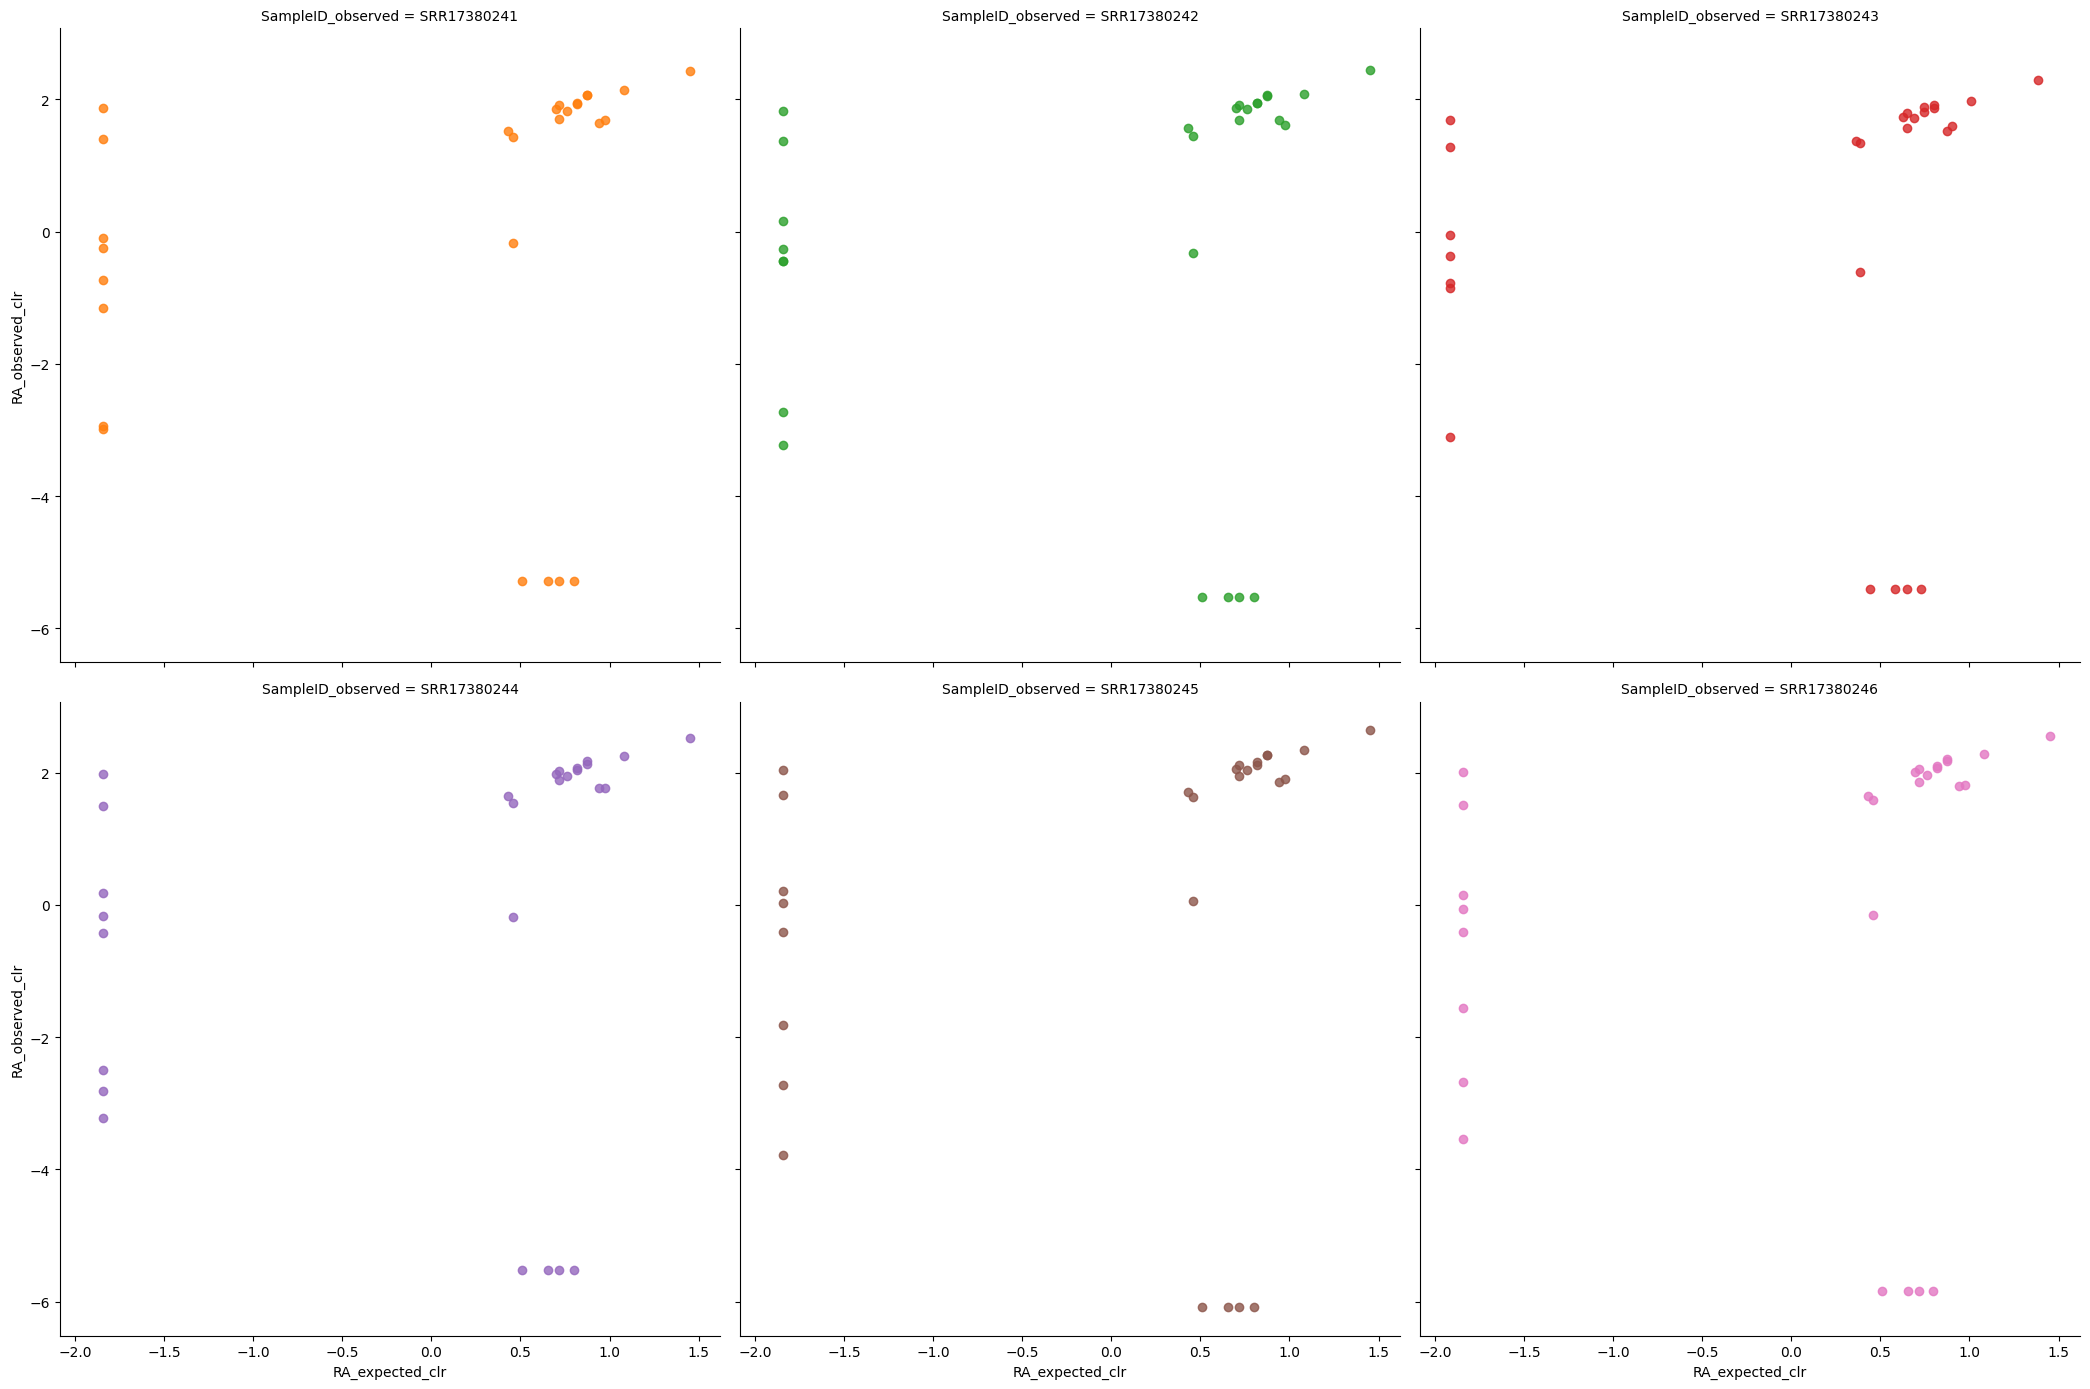

In [142]:
def main():
    # This is the minimum RA abundance.
    # filtering_threshold = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    filtering_threshold = [0, 1e-5, 1e-4, 1e-3, 1e-2]
    filtering_with_bars = [1e-4, 1e-3, 1e-2]
    # john_filter = [1e-3]
    # john_filter = [1e-4]

    def one_to_one(thresh: float):
        for exp in root_dirs_one_to_one:
            print("Experiment: ", exp.root)
            # plot_by_sample(root=exp.root, output_dir=exp.root, hue_category="Source", taxonomic_rank="Genus", threshold=thresh)
            # plot_by_sample(root=exp.root, output_dir=exp.root, hue_category="Source", taxonomic_rank="Species", threshold=thresh)
            # final_stats_genus = convert_to_bivariate(exp.root, save_path=exp.root, inset=exp.inset, rank="Genus", threshold=thresh)
            # final_stats_genus.to_csv(os.path.join(exp.root, f"{str(thresh)}_all_stats_replicates_genus.csv"), index_label="SampleID")
            final_stats = convert_to_bivariate(exp.root, save_path=exp.root, inset=exp.inset, rank="Species", threshold=thresh)
            final_stats.to_csv(os.path.join(exp.root, f"{str(thresh)}_all_stats_replicates_species.csv"), index_label="SampleID")

    def many_to_one(thresh: float):
        for exp in root_dirs_one_to_many:
            print("Experiment: ", exp.root)
            # plot_many_versus_expected(exp.root, exp.root, fully_combined(exp.root, rank="genus"), "genus", thresh)
            # plot_many_versus_expected(exp.root, exp.root, fully_combined(exp.root, rank="species"), "species", thresh)
            # final_stats_genus = plot_many_versus_expected_bivariate(exp.root, fully_combined(exp.root, rank="genus"), get_all_expected(exp.root, "genus"), "genus", inset=exp.inset, threshold=thresh)
            # final_stats_genus.to_csv(os.path.join(exp.root, f"{str(thresh)}_all_stats_replicates_genus.csv"), index_label="SampleID")
            final_stats = plot_many_versus_expected_bivariate(exp.root, fully_combined(exp.root, rank="species"), get_all_expected(exp.root, "species"), "species", inset=exp.inset, threshold=thresh)
            final_stats.to_csv(os.path.join(exp.root, f"{str(thresh)}_all_stats_replicates_species.csv"), index_label="SampleID")

    for thresh in filtering_with_bars:
        print("Threshold: ", thresh)
        # one_to_one(thresh=thresh)
        many_to_one(thresh=thresh)

    # one_to_one(thresh=0.01)
    # many_to_one(thresh=0.001)
    pdf_output.close()
   
main()

# TODO: Recode the sources to be wgsa2, wotlka, bio4, jams.

In [ ]:
def gather_expected(pipeline_list: List[Pipeline]) -> None:
    for exp in pipeline_list:
        expected = get_all_expected(exp.root, rank = "Species")
        expected["Pipeline"] = os.path.basename(exp.root)
        expected.to_csv("expected_combined.csv", mode='a', header=False)

# gather_expected(root_dirs_one_to_one)
# gather_expected(root_dirs_one_to_many)

# for exp in root_dirs_one_to_many:
#     expected = get_all_expected(exp.root, rank = "Species")

# fc = fully_combined("pipelines/bmock12/")